- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

# IMPORT LIBRARIES AND DATASETS

In [1]:
# Configuration and paths
import os
from pathlib import Path

# Set base directory (notebooks are in notebooks/, data is in parent directory)
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'

# Ensure directories exist
DATA_DIR.mkdir(exist_ok=True)

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import glob
import random

# Configure matplotlib for better visualization
plt.style.use('default')
%matplotlib inline

2025-12-08 23:05:08.164822: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 23:05:08.631727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 23:05:09.927952: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Google Colab code removed - running locally
# Data should be in the 'data' directory relative to the notebook

In [3]:
# Google Colab directory change removed - running locally
# Working directory is already set to the project root


In [4]:
# save the paths to Brain MRI and their corresponding mask
# Uncomment and run this cell if you need to regenerate route_label.csv
'''
from glob import glob
mask_files = glob(str(DATA_DIR / '*/*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
brain_df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "mask":[label(x) for x in mask_files]})
brain_df.to_csv(DATA_DIR / 'route_label.csv')
'''


'\nfrom glob import glob\nmask_files = glob(str(DATA_DIR / \'*/*_mask*\'))\ntrain_files = [file.replace(\'_mask\', \'\') for file in mask_files]\ndef label(mask):\n    value = np.max(cv2.imread(mask))\n    return \'1\' if value > 0 else \'0\'\nbrain_df = pd.DataFrame({"image_path": train_files,\n                   "mask_path": mask_files,\n                  "mask":[label(x) for x in mask_files]})\nbrain_df.to_csv(DATA_DIR / \'route_label.csv\')\n'

In [5]:
# Load data from data directory
brain_df = pd.read_csv(DATA_DIR / 'route_label.csv', index_col=0)
brain_df.head(10)

image_path  \
0  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
1  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
2  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
3  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
4  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
5  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
6  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
7  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
8  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   
9  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...   

                                           mask_path  mask  
0  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     0  
1  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     0  
2  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     0  
3  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  
4  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  
5  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     0  
6  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     0  
7  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  
8  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     1  
9  ./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...     0

# DATA VISUALIZATION

In [6]:
# Obtain the number of images with mask
brain_df['mask'].value_counts()

mask
0    2533
1    1366
Name: count, dtype: int64

In [7]:
# Use plotly to plot interactive bar chart
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

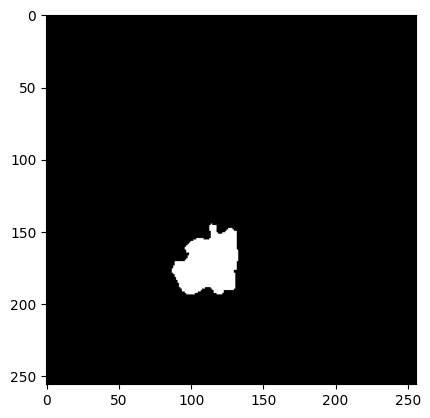

In [8]:
plt.imshow(cv2.imread(brain_df.mask_path[513]))

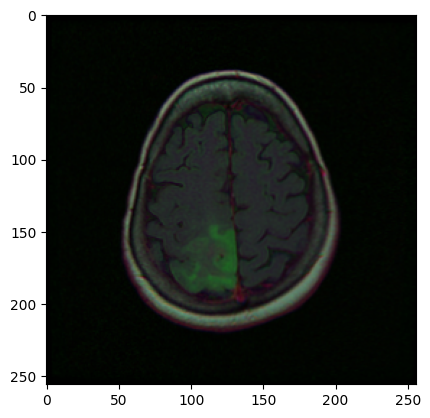

In [9]:
plt.imshow(cv2.imread(brain_df.image_path[513]))

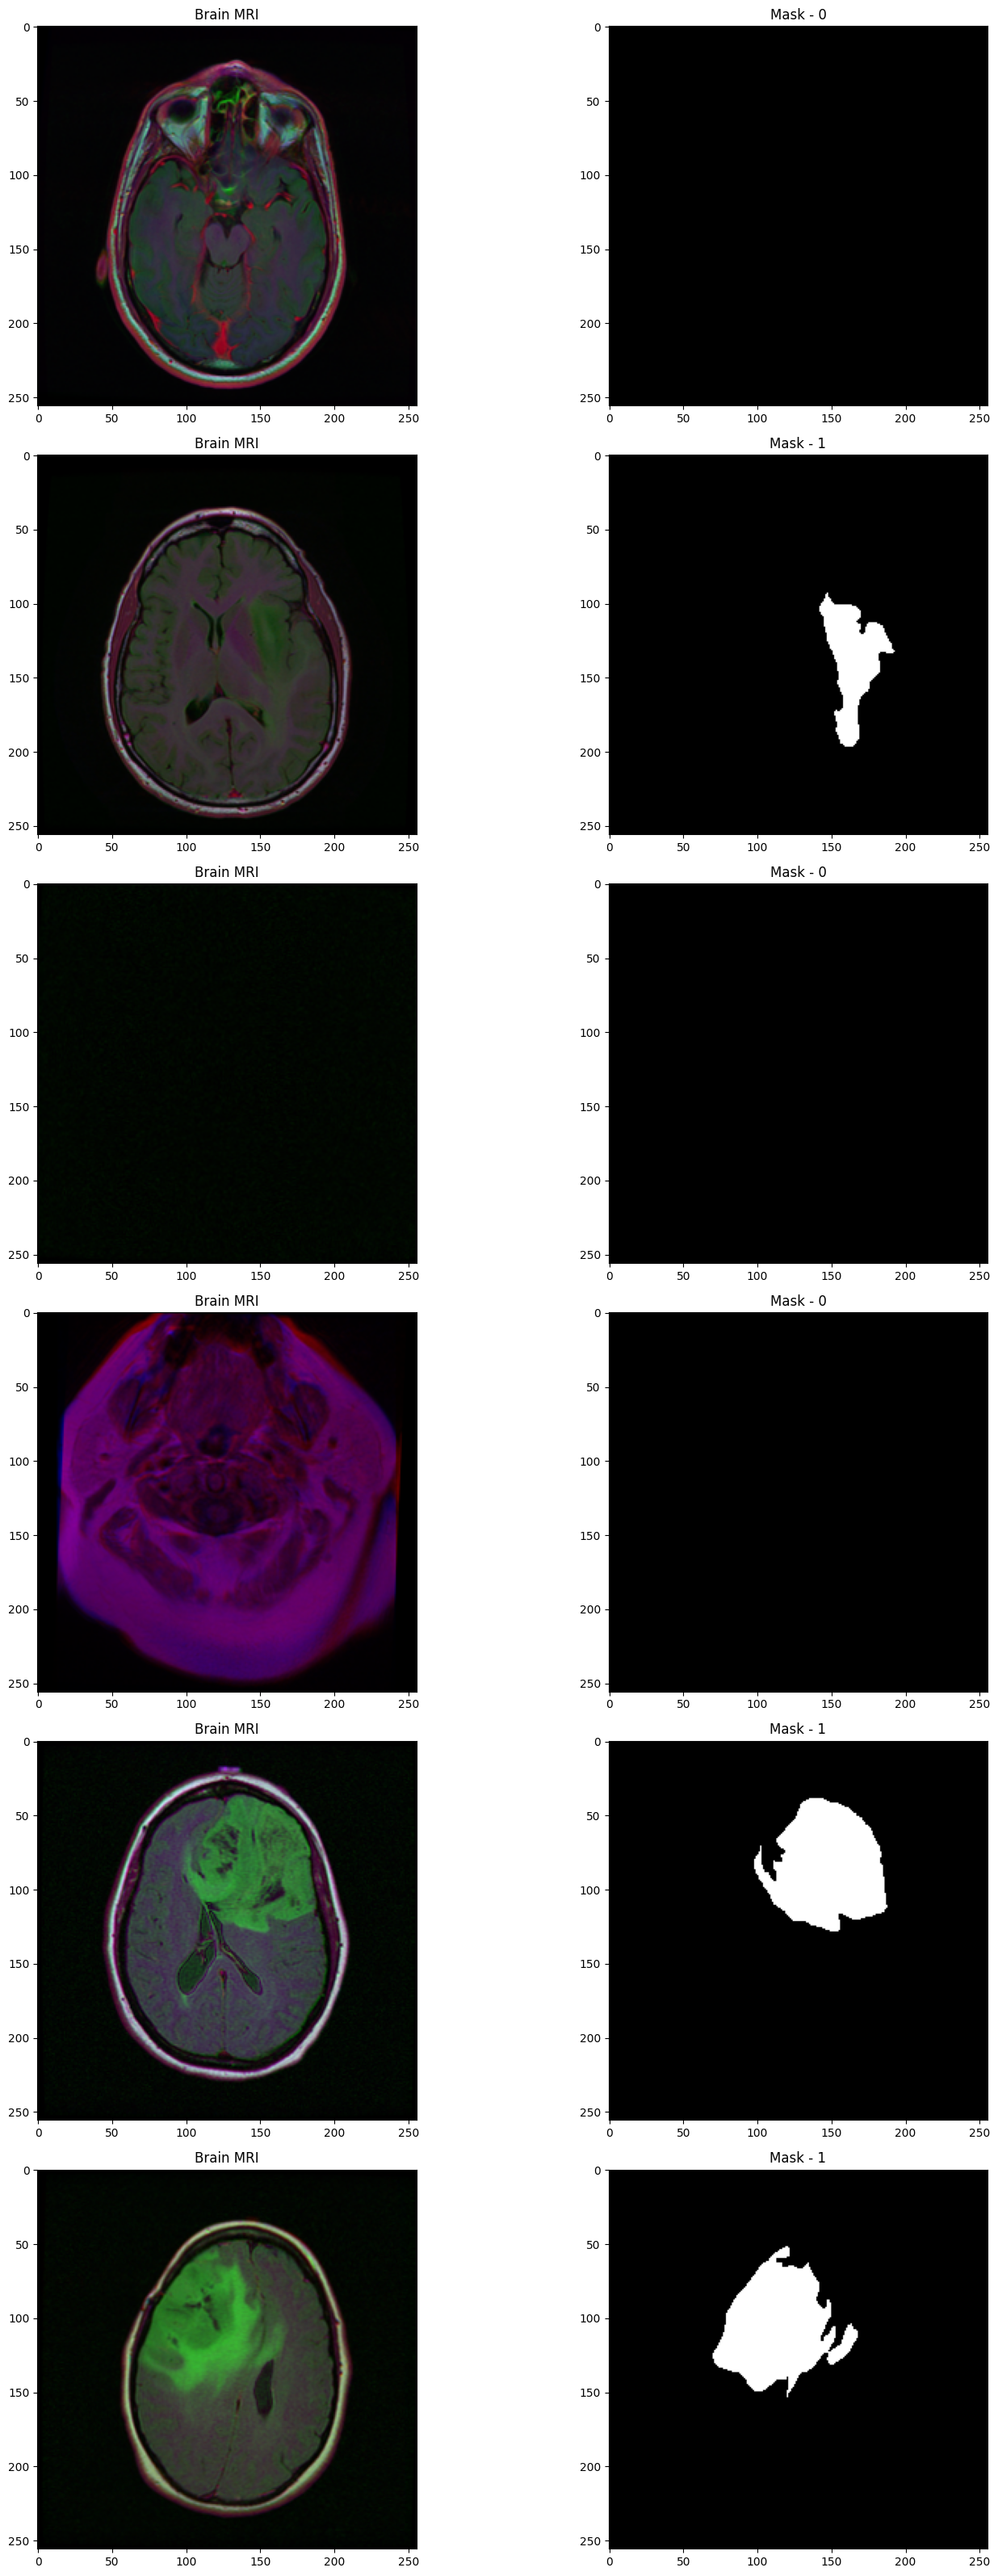

In [10]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

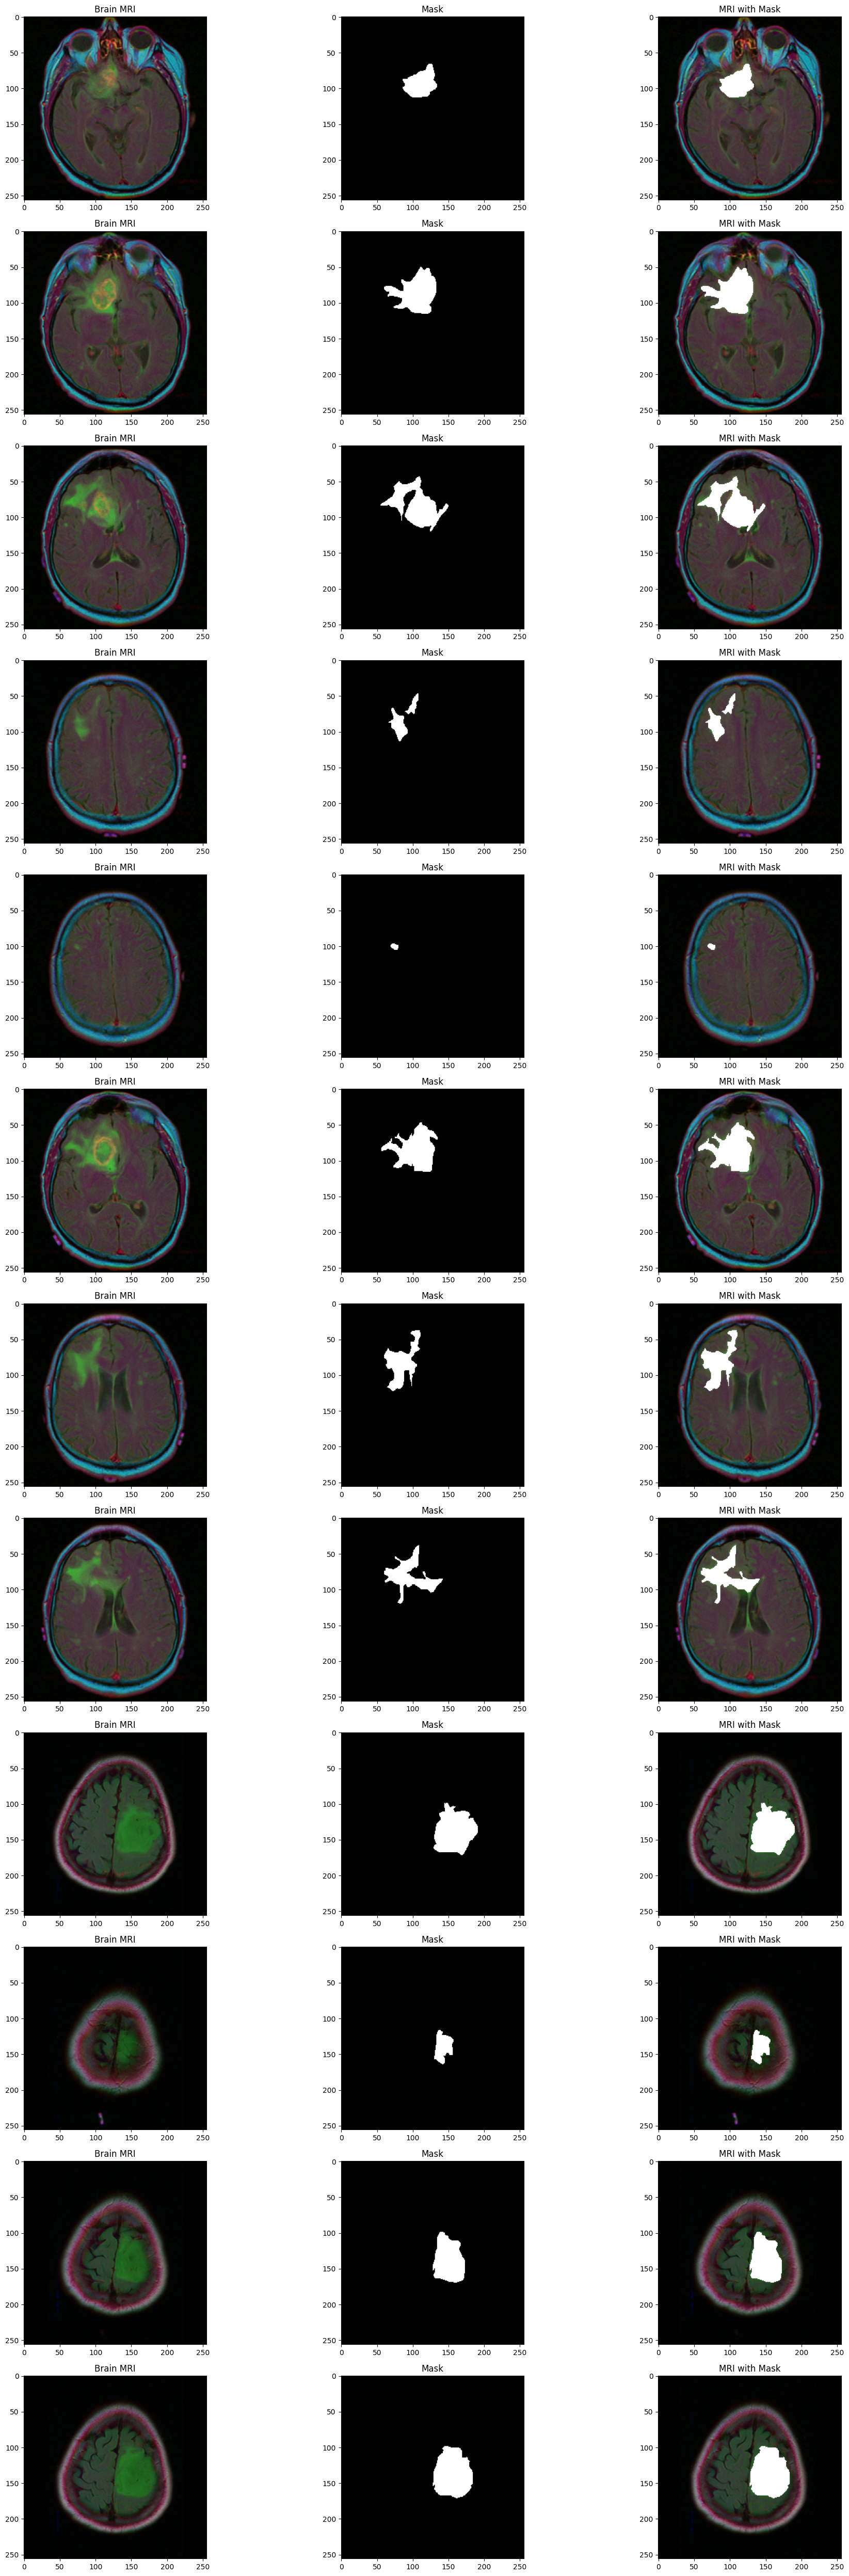

In [11]:
# Advanced Visualization: visualize the MRI scans along with their mask on one image
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # read the images
    img = io.imread(brain_df.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # obtain the mask for the image
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # replace the values in the image with red color (255,0,0) if any mask pixel in the mask was = 255
    img[mask == 255] = (255,255,255)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count= 1+count

fig.tight_layout()